<br>Model from:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

-----------------------------------------
# Data visualization

In [40]:
import sys
sys.executable

'/usr/bin/python3'

In [41]:
%matplotlib inline
%load_ext autoreload
%autoreload

import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.nasnet import NASNetMobile
# from keras.applications import NASNetMobile
# from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average
from keras.layers import Input, Concatenate, GlobalMaxPooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
from keras import utils as np_utils
from livelossplot import PlotLossesKeras

import cv2

sys.path.insert(0, '../')
from src.dataGenerator import *

# import src.constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

['/job:localhost/replica:0/task:0/device:GPU:0']

In [43]:
# Output files
OUTPUT_DIR = "output_model2_2/"
!mkdir output_model2_2/

OUTPUT_TENSORBOARD_DIR = OUTPUT_DIR+"/logs/"
!mkdir output_model2_2/logs/
# !tensorboard --logdir=output_model2_2/logs/

# MODEL_SUMMARY_FILE = OUTPUT_DIR + "model_summary.txt"
MODEL_PLOT_FILE = OUTPUT_DIR + "model_plot.png"

# Path to images
DATA_DIR = "../data"

TRAINING_LOGS_FILE_2 = OUTPUT_DIR + "training_logs_aug.csv"
MODEL_FILE_2 = OUTPUT_DIR + "model_aug.h5"
TRAINING_PLOT_FILE_2 = OUTPUT_DIR + "training_aug.png"
VALIDATION_PLOT_FILE_2 = OUTPUT_DIR + "validation_aug.png"
ROC_PLOT_FILE_2 = OUTPUT_DIR + "roc_aug.png"

KAGGLE_SUBMISSION_FILE_2 = OUTPUT_DIR + "kaggle_submission_aug.csv"

# Hyperparams
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 13
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

mkdir: cannot create directory ‘output_model2_2/’: File exists


In [44]:
data = pd.read_csv(DATA_DIR + '/train_labels.csv')
print(data['label'].value_counts())
training_data, validation_data = train_test_split(data, train_size=TRAINING_RATIO, stratify=data['label'])
print(training_data['label'].value_counts())
print(validation_data['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64
0    117817
1     80205
Name: label, dtype: int64
0    13091
1     8912
Name: label, dtype: int64


/usr/local/lib/python3.5/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [45]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': True}

training_generator_with_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_with_aug = DataGenerator(validation_data.id, validation_data.label, **params)

Data augmentation enabled
Data augmentation enabled


In [46]:
# path = "data/train/" + training_data.id[np.random.randint(training_data.shape[0])] + ".tif"
# image = readImage(path)
# plt.figure()
# print("Original image")
# plt.imshow(image)
# plt.show()
# print("Augmented images")
# aug_images = training_generator_with_aug.augment([image], show = True)

In [47]:
# Model
def create_model(file = ''):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', 
                     input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = "sigmoid"))
    
    if (os.path.exists(file) == True):
        print("Load model from file: ", file)
        model = load_model(file)

    # Compile the model
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    model.summary()

    plot_model(model,
               to_file=MODEL_PLOT_FILE,
               show_shapes=True,
               show_layer_names=True)
    
    return model

def train(model, training_generator, validation_generator, model_file, logs_file):
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    workers=6,
                    epochs=EPOCHS,
                            callbacks=[PlotLossesKeras(),
                                        ModelCheckpoint(model_file,
                                                     monitor='val_acc',
                                                     verbose=VERBOSITY,
                                                     save_best_only=True,
                                                     mode='max'),
                                         CSVLogger(logs_file,
                                                   append=False,
                                                   separator=';')])

In [48]:
model_with_aug = create_model(MODEL_FILE_2)

Load model from file:  output_model2_2/model_aug.h5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)       

In [49]:
TRAINING_LOGS_FILE_2

'output_model2_2/training_logs_aug.csv'

In [50]:
history = train(model = model_with_aug, 
            training_generator = training_generator_with_aug,
            validation_generator = validation_generator_with_aug,
            model_file = MODEL_FILE_2,
            logs_file = TRAINING_LOGS_FILE_2)

Epoch 1/13
 117/1031 [==>...........................] - ETA: 6:28 - loss: 0.5344 - acc: 0.7318

Process ForkPoolWorker-68:
Process ForkPoolWorker-71:
Process ForkPoolWorker-72:
Process ForkPoolWorker-64:
Process ForkPoolWorker-73:
Process ForkPoolWorker-74:
Process ForkPoolWorker-70:
Process ForkPoolWorker-65:
Process ForkPoolWorker-66:
Process ForkPoolWorker-69:
Process ForkPoolWorker-63:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/pyt

Traceback (most recent call last):
  File "../src/dataGenerator.py", line 52, in __getitem__
    X, y = self.__data_generation(list_IDs_temp, list_labels_temp)
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 342, in get
    with self._rlock:
  File "/usr/local/lib/python3.5/dist-packages/keras/utils/data_utils.py", line 401, in get_index
    return _SHARED_SEQUENCES[uid][i]
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.5/multiprocessing/synchronize.py", line 96, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/p

KeyboardInterrupt: 

  File "/home/yevhenp/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 2823, in _augment_images
    hooks=hooks
  File "/home/yevhenp/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 515, in augment_images
    hooks=hooks
  File "/home/yevhenp/.local/lib/python3.5/site-packages/imgaug/augmenters/meta.py", line 3118, in _augment_images
    hooks=hooks


In [ ]:
def plot_epochs(history, training_plot_file, validation_plot_file):
    # Training plots
    epochs = [i for i in range(1, len(history.history['loss'])+1)]

    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('training')
    plt.xlabel('epoch')
    plt.savefig(training_plot_file, bbox_inches='tight')
    plt.close()

    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('validation')
    plt.xlabel('epoch')
    plt.savefig(validation_plot_file, bbox_inches='tight')
    plt.close()

In [ ]:
def plot_AUC(model, testing_generator, model_file, plot_file):
    # ROC testing plot
#     model.load_weights(model_file)
    predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
#     print(len(testing_generator))
#     print(testing_generator.classes.shape)
#     print(predictions.shape)
#     print(predictions)
    false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    
    print("False positive: ", false_positive_rate)
    print("True positive: ", true_positive_rate)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()


In [ ]:
def test(model, file):
    testing_files = glob(os.path.join('data/test/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        data_frame['label'] = predictions
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(file, index=False, header=True)

In [ ]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': False,
          'augmentation': False}

testing_generator = DataGenerator(validation_data.id, validation_data.label, **params)
# plot_epochs(history, TRAINING_PLOT_FILE_1, VALIDATION_PLOT_FILE_1)

114/114 [==============================] - 10s 91ms/step
False positive:  [0.         0.         0.         ... 0.98049155 0.98049155 1.        ]
True positive:  [0.02119982 0.0267253  0.03755074 ... 0.99988724 1.         1.        ]


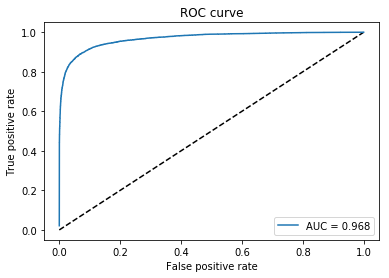

In [15]:
plot_AUC(model_with_aug, testing_generator, MODEL_FILE_2, ROC_PLOT_FILE_2)

In [16]:
test(model = model_with_aug, file = KAGGLE_SUBMISSION_FILE_2)

In [17]:
print("Run model without augmentation")

Run model without augmentation


In [18]:
# Parameters
params = {'dim': (IMAGE_SIZE, IMAGE_SIZE),
          'batch_size': BATCH_SIZE,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation': False}

training_generator_no_aug = DataGenerator(training_data.id, training_data.label, **params)
validation_generator_no_aug = DataGenerator(validation_data.id, validation_data.label, **params)

In [19]:
model_no_aug = create_model(MODEL_FILE_1)

Load model from file:  output_model2_2/model_no_aug.h5


KeyboardInterrupt: 

In [ ]:
history = train(model = model_no_aug, 
                training_generator = training_generator_no_aug,
                validation_generator = validation_generator_no_aug,
                model_file = MODEL_FILE_1,
                logs_file = TRAINING_LOGS_FILE_1)

In [ ]:
# plot_epochs(history, TRAINING_PLOT_FILE_2, VALIDATION_PLOT_FILE_2)
plot_AUC(model_no_aug, testing_generator, MODEL_FILE_1, ROC_PLOT_FILE_1)

In [ ]:
test(model = model_no_aug, file = KAGGLE_SUBMISSION_FILE_1)
